# Quantum Fourier transformation tutorial


In [1]:
import sys
sys.path.append('c:\\Users\\Amy\\Desktop\\Green_Git\\hierarqcal')


In [2]:
import numpy as np
import sympy as sp
import matplotlib.pyplot as plt
from hierarqcal import (
    Qhierarchy,
    Qcycle,
    Qpermute,
    Qmask,
    Qunmask,
    Qinit,
    Qmotif,
    Qmotifs,
    plot_motif,
    Qunitary,
    Qpivot,
)

## Specify backend
It is possible to use the package without a specific backend, but we choose one here for visualisation purposes. We're mainly going to use the backends plotting functionality to display the circuits, so pick the one you have installed.

In [3]:
backend = "qiskit"

In [4]:
if backend == "qiskit":
    import qiskit
    from hierarqcal.qiskit.qiskit_circuits import V2, U2, V4

    def get_circuit(hierq):
        return hierq(backend="qiskit")

    def draw_circuit(circuit, **kwargs):
        return circuit.draw(output="mpl", **kwargs)

elif backend == "cirq":
    import cirq
    from cirq.contrib.svg import SVGCircuit
    from hierarqcal.cirq.cirq_circuits import V2, U2, V4
    import logging
    logging.getLogger('matplotlib.font_manager').disabled = True
    def get_circuit(hierq):
        return hierq(backend="cirq")

    def draw_circuit(circuit, **kwargs):
        return SVGCircuit(circuit, **kwargs)

elif backend == "pennylane":
    import pennylane as qml
    from hierarqcal.pennylane.pennylane_circuits import V2, U2, V4

    def get_circuit(hierq):
        dev = qml.device("default.qubit", wires=hierq.tail.Q)

        @qml.qnode(dev)
        def circuit():
            if isinstance(next(hierq.get_symbols(), False), sp.Symbol):
                # Pennylane doesn't support symbolic parameters, so if no symbols were set (i.e. they are still symbolic), we initialize them randomly
                hierq.set_symbols(np.random.uniform(0, 2 * np.pi, hierq.n_symbols))
            hierq(
                backend="pennylane"
            )  # This executes the compute graph in order
            return [qml.expval(qml.PauliZ(wire)) for wire in hierq.tail.Q]

        return circuit

    def draw_circuit(circuit, **kwargs):
        fig, ax = qml.draw_mpl(circuit)(**kwargs)

## Discrete Fourier transformation
For an input vector $\vec{x}$, the $k$ th element of the transformed vector is given by
$$y_k = \frac{1}{\sqrt{N}} \sum^{N-1}_{j=0} x_j e^{2\pi ijk/N}\,.$$

Generalizing this to a set of state $|0\rangle, |1\rangle, \dots |N-1\rangle$ we have
$$|j\rangle \rightarrow \frac{1}{\sqrt{N}} \sum^{N-1}_{k=0} e^{2\pi ijk/N}|k\rangle\,,$$
so that the Quantum Fourier transform for an arbitrary state is given by
$$\sum_{j=0}^{N-1} x_j |j\rangle \rightarrow \frac{1}{\sqrt{N}}  \sum^{N-1}_{k=0} \sum_{j=0}^{N-1} x_j e^{2\pi ijk/N}|k\rangle =   \sum^{N-1}_{k=0} y_k|k\rangle\,.$$

Let us assume that $N=2^n$, then it is straightforward to check that 
$$|j\rangle \rightarrow  \frac{1}{2^{\frac{n}{2}}} \sum^{N-1}_{k=0} e^{2\pi ijk/2^{\frac{n}{2}}}|k\rangle = \frac{1}{2^{\frac{n}{2}}} \otimes^{n}_{l=1} \left[|0\rangle+ e^{2\pi ij2^{-l}}|1\rangle \right] = \frac{1}{2^{\frac{n}{2}}} (|0\rangle+ e^{2\pi i 0.j_n}|1\rangle )(|0\rangle+ e^{2\pi i 0.j_{n-1}j_n}|1\rangle)\dots(|0\rangle+ e^{2\pi i 0.j_1j_2\dots j_n}|1\rangle)\,,$$
where $0.j_1j_2\dots j_n$ represents the binary fraction $j_1/2+j_2/2^2+\dots j_n/2^n$.

See Nielsen, Michael A., and Isaac L. Chuang. ["Quantum computation and quantum information."](https://en.wikipedia.org/wiki/Quantum_Computation_and_Quantum_Information) Chapter 5 for further explanation.

In [5]:
n = 5
N = 2^n

## Primitive circuit 

Let us construct the unitary, $U_k$, that performs the following transformation
$$\otimes^{n-1}_{l=0} |0\rangle \rightarrow \otimes^{k-1}_{l=0} |0\rangle (|0\rangle+ e^{2\pi i 0.j_{n-k}\dots j_n}|1\rangle) \otimes^{n-1}_{l=k+1} |0\rangle\,.$$
The unitary, $U_k$, can be implements using a Hadamard gate applied to the $k$ th bit, followed by a series of controlled phase gates of the form 
$$P_l = \begin{pmatrix} 1&0 \\ 0 & e^{2\pi i/2^l} \end{pmatrix}$$
which act on the $(k+1)$ th bit conditioned on the state of the $l$ th bit, where $n \geq l > (k+1)$.

In [6]:
# Hadamard
h = Qpivot(mapping=Qunitary(f"h()^0"))
# controlled phase
controlled_p = Qpivot(mapping=Qunitary(f"cp(x)^10"), share_weights=False)

In [46]:
k = 3

In [47]:

qc_k = Qinit(n) + Qmask("1"*(k-1)+"*") + h + controlled_p

In [48]:
circuit= qc_k(backend="qiskit")

In [49]:
params = {}
for p in circuit.parameters:
    i = int(p.name.split("_")[-1])
    # print(i, 2+i)
    params[p] = 2*np.pi*2**(-(2+i))

circuit = circuit.assign_parameters(params)

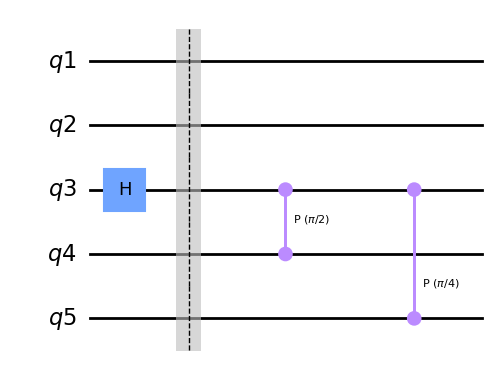

In [50]:
circuit.draw("mpl")

## Sequence of primitives

In [51]:
qft = Qinit(n)  + (h + controlled_p + Qmask("1*"))*(n)
circuit= qft(backend="qiskit")

In [52]:
params = {}
count = 0
i = 0
for p in circuit.parameters:
    # print(i, 2+i)
    params[p] = 2*np.pi*2**(-(2+i))
    i+=1
    if i == n-1-count:
        count += 1
        i = 0

circuit = circuit.assign_parameters(params)

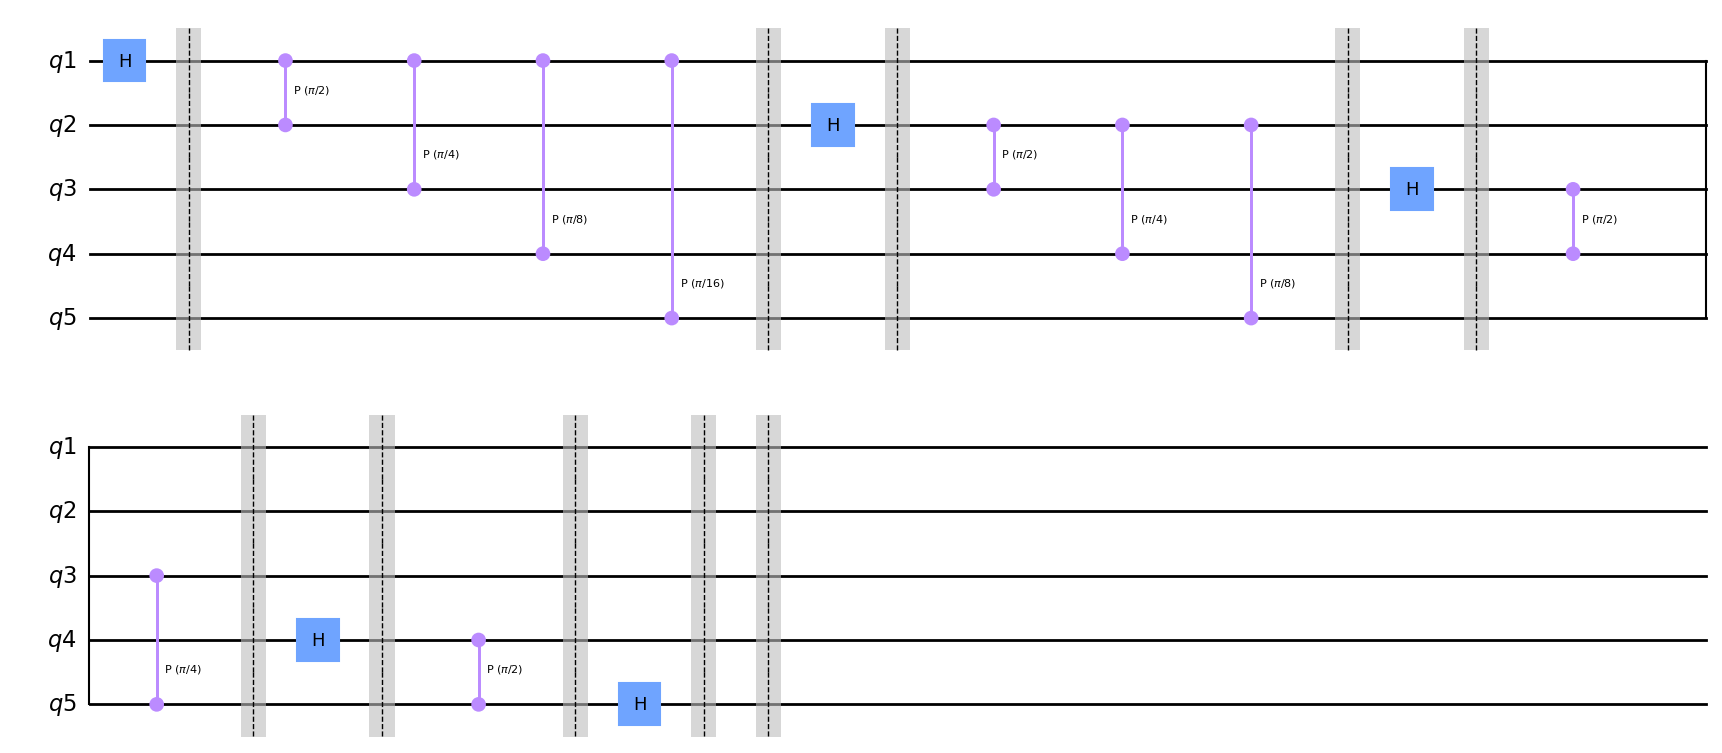

In [53]:
circuit.draw("mpl")

## Does this perform as intended?

It turns out that the circuit transforms the state $|0\rangle$ (understood as all qubits in state $|0\rangle$) to the state
$$\frac{1}{2^{\frac{n}{2}}} (|0\rangle+ e^{2\pi i 0.j_1j_2\dots j_n}|1\rangle) \dots (|0\rangle+ e^{2\pi i 0.j_{n-1}j_n}|1\rangle) (|0\rangle+ e^{2\pi i 0.j_n}|1\rangle )\,.$$ 
In fact the order of the qubits is reversed. This can be fixed by performing a series of "swap" operation. However for simplicity we can simply assume that the user is aware that they should in fact read the bit string in reverse. 

## Experiments

Zero intial state, equal superposition, random state -> compare to fft